In [1]:
%load_ext autoreload

%autoreload 2


# from https://nbviewer.jupyter.org/github/napsternxg/pytorch-practice/blob/master/Pytorch%20Uncertainity-animated.ipynb

In [2]:
%matplotlib inline

import numpy as np
import torch

from matplotlib import animation
#Writer = animation.writers['pillow']
#writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

import matplotlib.pyplot as plt


import seaborn as sns
ffmpeg_path = 'C://Users//thoma//Documents//ffmpeg//FFmpeg//bin'#//bin'
#C:\Users\thoma\Documents\ffmpeg\FFmpeg\bin
#plt.rcParams['animation.ffmpeg_path'] = ffmpeg_path

from tqdm import tqdm, trange
from ipywidgets import interact, fixed
from IPython.display import HTML, display
import os

In [3]:
plt.rcParams["figure.figsize"] = (20,10)


In [4]:
os.listdir(ffmpeg_path)

['ffmpeg.exe', 'ffplay.exe', 'ffprobe.exe']

In [5]:
sns.set_context("poster")
sns.set_style("ticks")

np.random.seed(101217209)

In [6]:
from src.data_generators import get_data

In [7]:
#x,y = generate_data_()

In [8]:
#plt.plot(x,y)

In [9]:
N = 100
min_x, max_x = -3, 1
(X_obs, y_obs, X_true, y_true), (w, b, true_model) = get_data(N, min_x, max_x)

In [10]:
# plt.plot(X_obs, y_obs, ls="none", marker="o", color="k", label="observed")
# plt.plot(X_true, y_true, ls="-", color="r", label="true")
# plt.legend()
# sns.despine(offset=10)

In [11]:
from src.models import BootstrapEnsemble

In [12]:
from src.helpers import uncertainity_estimate, plot_model


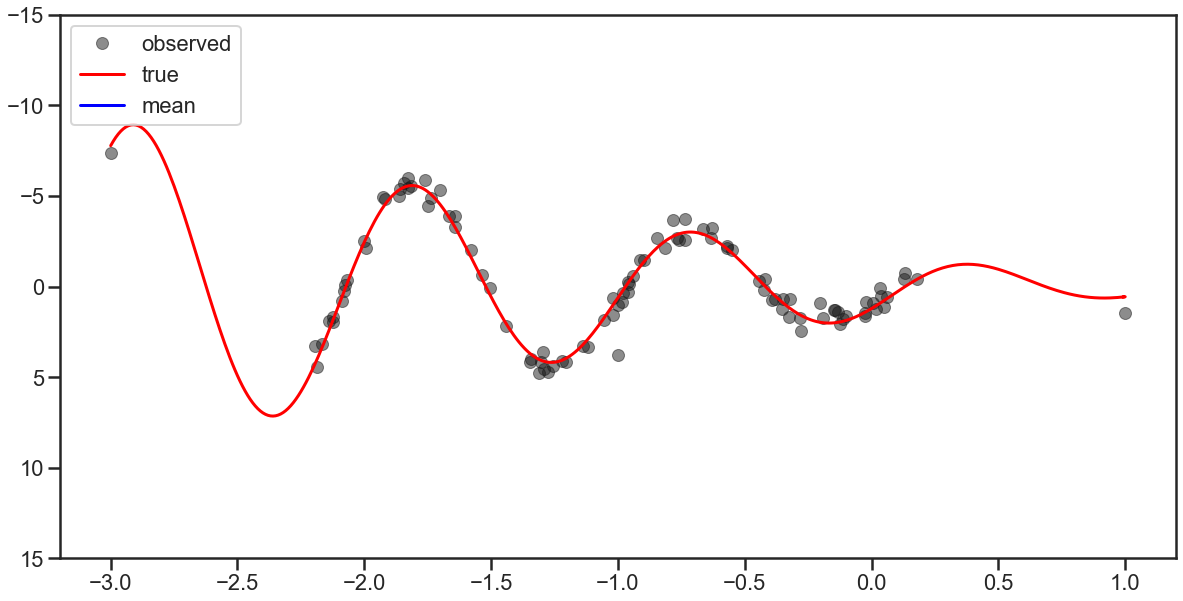

In [13]:
ensemble = BootstrapEnsemble(X_obs,y_obs,X_true,y_true,p=0.00, decay=0.001, non_linearity=torch.nn.LeakyReLU, n_models=10, model_list=None,u_iters=100, l2=1, n_std=4, title="",dataset_lenght =len(y_obs))

In [14]:
#y_mean, y_std = uncertainity_estimate(X_true, model, 200)
y_mean, y_std = ensemble.ensemble_uncertainity_estimate(X_true, ensemble, 200)

In [15]:
#y_mean

In [16]:
#criterion = torch.nn.MSELoss()
#optimizer = torch.optim.Adam(
#    model.parameters(),
#    weight_decay=model.decay)

In [17]:
def fit_model(model, optimizer):
    y = Variable(torch.Tensor(y_obs[:, np.newaxis]), requires_grad=False)
    y_pred = model(X_obs[:, np.newaxis])
    optimizer.zero_grad()
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 93.76it/s]


loss=[tensor(0.5548, grad_fn=<MseLossBackward>), tensor(3.1576, grad_fn=<MseLossBackward>), tensor(0.2147, grad_fn=<MseLossBackward>), tensor(0.2315, grad_fn=<MseLossBackward>), tensor(2.0999, grad_fn=<MseLossBackward>), tensor(0.4693, grad_fn=<MseLossBackward>), tensor(0.4579, grad_fn=<MseLossBackward>), tensor(0.2867, grad_fn=<MseLossBackward>), tensor(0.7705, grad_fn=<MseLossBackward>), tensor(0.2546, grad_fn=<MseLossBackward>)]


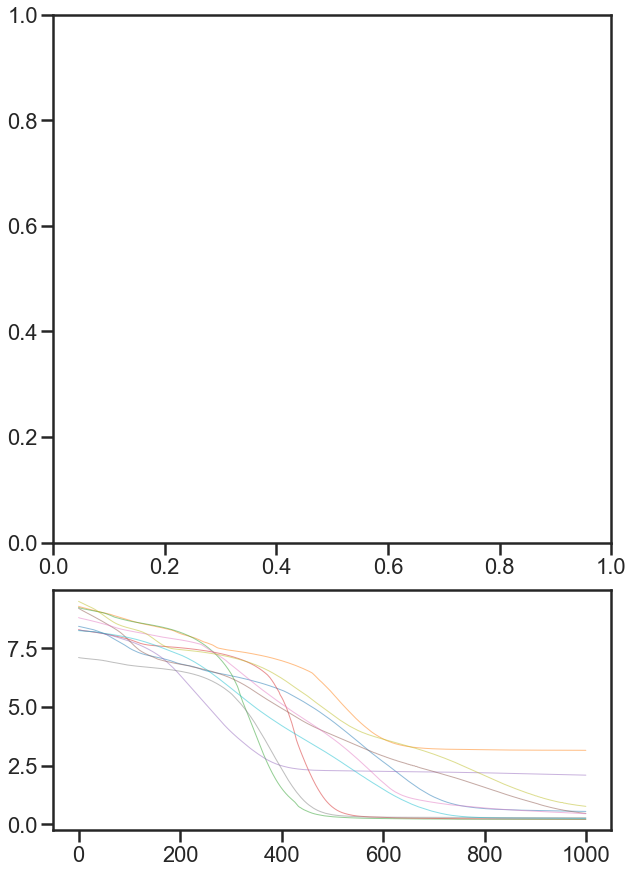

In [18]:
fig = plt.figure(figsize=(10, 15))
ax0 = plt.subplot2grid((3,1), (0, 0), rowspan=2)
ax1 = plt.subplot2grid((3,1), (2, 0))
losses = []
for i in trange(1000):
    loss = ensemble.fit_ensemble(X_obs,y_obs)
    losses.append(loss)
print("loss={}".format(loss))
ax1.plot(losses, ls="-", lw=1, alpha=0.5)
#plot_model(model, l2=0.01, ax=ax0)

<Figure size 1440x720 with 0 Axes>

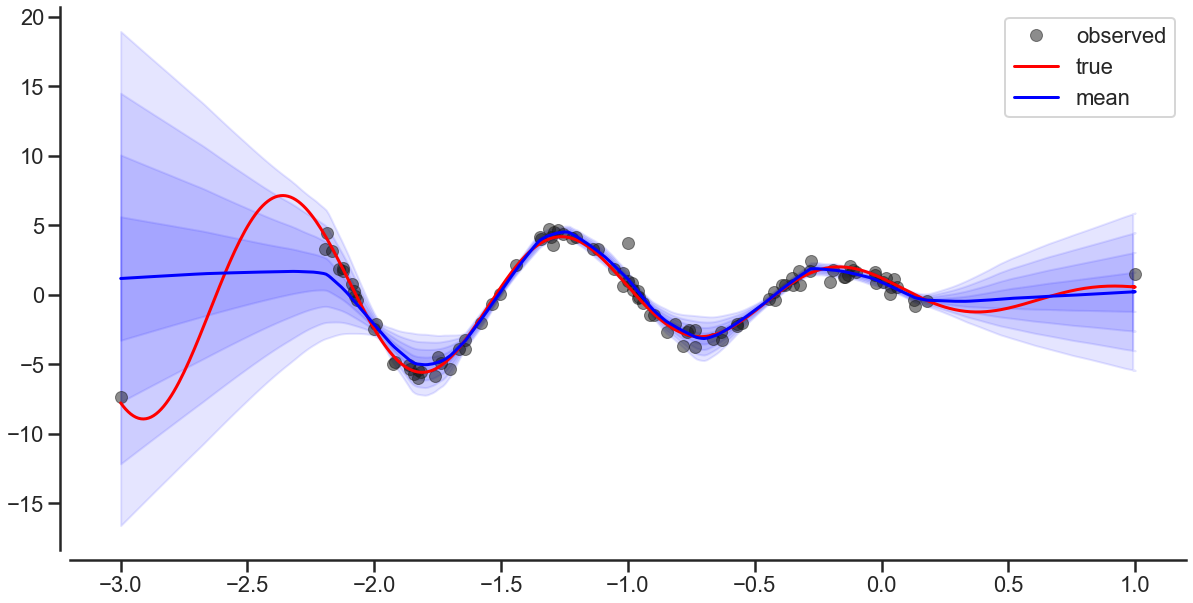

In [19]:
plot_model(ensemble,X_true,y_true,X_obs,y_obs, n_std=4, l2=10)


In [20]:
#from src.base_animators import AnimateBootstrapEnsemble

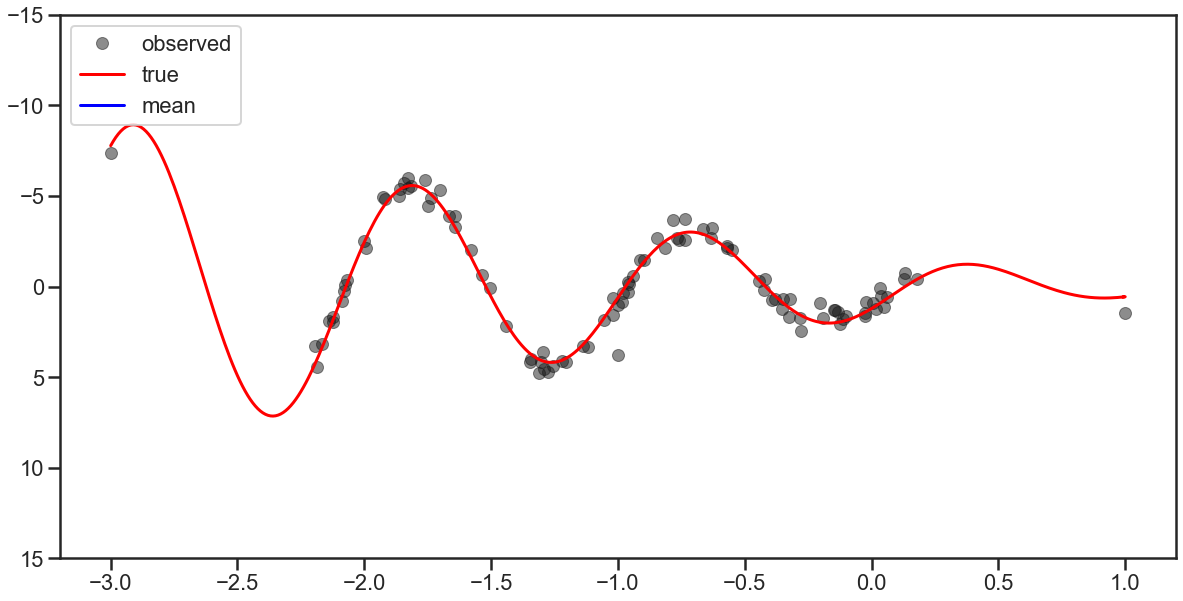

In [21]:
#model = AnimateVanillaEnsemble(p=0.1, decay = 1e-6, non_linearity=torch.nn.LeakyReLU)
animate_obj = BootstrapEnsemble(X_obs,y_obs,X_true,y_true,p=0.00, decay=0.001, non_linearity=torch.nn.LeakyReLU, n_models=10, model_list=None,u_iters=100, l2=1, n_std=4, title="",dataset_lenght =len(y_obs))
#,p=0.00, decay=0.001, non_linearity=torch.nn.LeakyReLU, n_models=10, model_list=None,u_iters=100, l2=1, n_std=4, title="",dataset_lenght=None

In [ ]:
animate_obj.train(100, interval=100)


In [ ]:
# !pip install ffmpeg

In [ ]:
! pip install ffmpeg-python


In [ ]:
! pip install Pillow